```julia
using Pkg
Pkg.activate(".")
Pkg.add("IJulia Plots Printf Revise Statistics")
Pkg.dev("..")
```

In [1]:
using Plots
using Printf
using Statistics

# The default format SVG creates figures of size 9600x6400
gr(fmt="png")
nothing

In [2]:
using Revise

In [3]:
using ReinforcementLearningSutton.Commons: LearningSarsa, PlayerεGreedy, Point, play_game
using ReinforcementLearningSutton.GridWorld: GameGridWorldStaticBase, GameGridWorldStatic

┌ Info: Precompiling ReinforcementLearningSutton [6417796d-59bf-4f93-aaf0-e2be7741ea64]
└ @ Base loading.jl:1278


In [4]:
nrows = 7
ncols = 10
pos_start = Point(1, 4)
pos_goal = Point(8, 4)

allowed_movements_all = ["cross" "queen" "queen_plus_freeze"]

wind_field = Array{Point, 2}(undef, nrows, ncols)

for (ncol, wind_y) in enumerate([0 0 0 1 1 1 2 2 1 0])
    for nrow in 1:nrows
        wind_field[nrow, ncol] = Point(0, wind_y)
    end
end

nothing

### Let's first play the game without wind

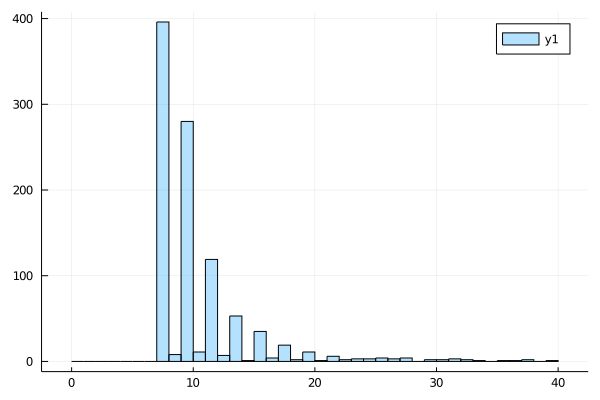

In [5]:
game = GameGridWorldStaticBase(nrows, ncols, pos_start, pos_goal, "cross")

ε = 0.1
player = PlayerεGreedy(game, ε)

α = 0.5
γ = 1.0
learning = LearningSarsa(player, α, γ)

max_nsteps = 1000
ngames = 1000
results = -[play_game(game, player, max_nsteps, learning) for _ in 1:ngames]
histogram(results, bins=0:1:40, fillalpha=0.3)

#### Let's add some wind

In [6]:
module GridWorldWindy

using ReinforcementLearningSutton.Commons: Point
using ReinforcementLearningSutton.GridWorld: GameGridWorldStatic, StateGridWorldStatic, ActionGridWorldStatic, state, state_set, ncols, nrows
import ReinforcementLearningSutton.GridWorld: update

abstract type Wind end

struct WindConstant <: Wind
    field::Array{Point, 2}
end

function wind(w::WindConstant, p::Point)
    w.field[p.y, p.x]
end

struct WindStochastic <: Wind
    field::Array{Point, 2}
    deltas::Array{Point, 1}
end

function wind(w::WindStochastic, p::Point)
    w.field[p.y, p.x] + rand(w.deltas)
end

function update(game::GameGridWorldStatic{<:Wind}, action::ActionGridWorldStatic)::Int
    s0 = state(game)
    w = wind(game.ruleset, s0.pos)
    
    pos_x = max(1, min(s0.pos.x + w.x + action.move.x, ncols(game)))
    pos_y = max(1, min(s0.pos.y + w.y + action.move.y, nrows(game)))
    s = StateGridWorldStatic(Point(pos_x, pos_y), nrows(game), ncols(game))
    state_set(game, s)
    -1
end

end

Main.GridWorldWindy

##### Constant wind

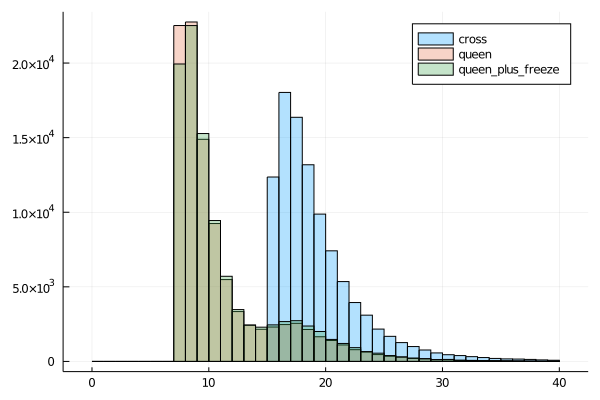

In [7]:
ε = 0.1
α = 0.5
γ = 1.0

wind_constant = GridWorldWindy.WindConstant(wind_field)

max_nsteps = 1000
ngames = 100000
results = zeros(Int, ngames, length(allowed_movements_all))
for (i, allowed_movements) in enumerate(allowed_movements_all)
    game0 = GameGridWorldStaticBase(nrows, ncols, pos_start, pos_goal, allowed_movements)
    game = GameGridWorldStatic(game0, wind_constant)
    
    player = PlayerεGreedy(game, ε)
    learning = LearningSarsa(player, α, γ)

    results[:, i] = -[play_game(game, player, max_nsteps, learning) for _ in 1:ngames]
end

histogram(results, bins=0:1:40, fillalpha=0.3, label=reshape(allowed_movements_all, 1, :))

In [8]:
median(results[900:end, :], dims=1)

1×3 Array{Float64,2}:
 18.0  9.0  9.0

##### Stochastic wind

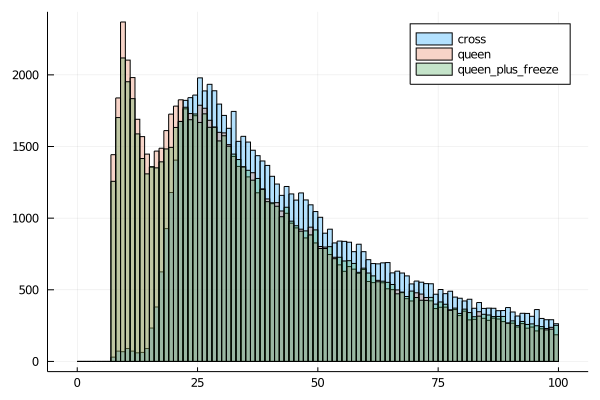

In [9]:
ε = 0.1
α = 0.5
γ = 1.0

wind_stochastic = GridWorldWindy.WindStochastic(wind_field, [Point(0, -1), Point(0, 0), Point(0, 1)])

max_nsteps = 1000
ngames = 100000
results = zeros(Int, ngames, length(allowed_movements_all))
for (i, allowed_movements) in enumerate(allowed_movements_all)
    game0 = GameGridWorldStaticBase(nrows, ncols, pos_start, pos_goal, allowed_movements)
    game = GameGridWorldStatic(game0, wind_stochastic)
    
    player = PlayerεGreedy(game, ε)
    learning = LearningSarsa(player, α, γ)

    results[:, i] = -[play_game(game, player, max_nsteps, learning) for _ in 1:ngames]
end

histogram(results, bins=0:1:100, fillalpha=0.3, label=reshape(allowed_movements_all, 1, :))

In [10]:
median(results[900:end, :], dims=1)

1×3 Array{Float64,2}:
 50.0  37.0  39.0